In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import shapefile

In [3]:
recorrido_bondis = pd.read_csv("./data/recorrido-colectivo.csv")
recorrido_metros = pd.read_csv("./data/recorrido-de-metrobus.csv")

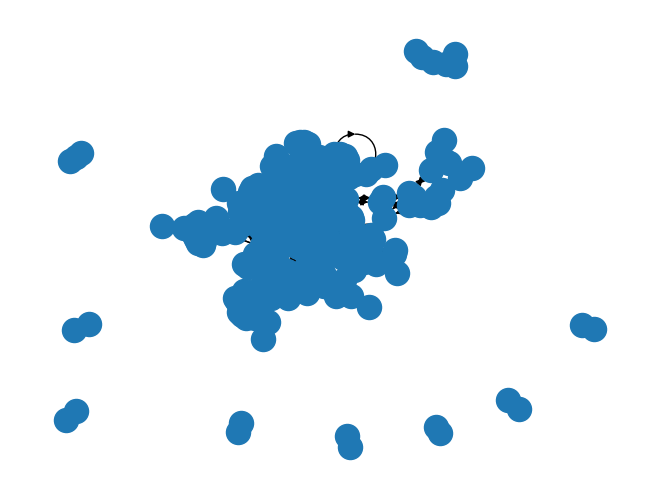

In [4]:
recorrido_bondis["desde"] = recorrido_bondis["desde"].str.replace(r'\(.*\)', '', regex=True).str.strip()
recorrido_bondis["hasta"] = recorrido_bondis["hasta"].str.replace(r'\(.*\)', '', regex=True).str.strip()

df_estaciones = pd.concat([recorrido_bondis["desde"], recorrido_bondis["hasta"]], ignore_index=True)
df_estaciones = df_estaciones.drop_duplicates().reset_index().drop("index", axis=1)
df_estaciones.columns = ["ids"]
df_estaciones_mapping = df_estaciones["ids"].reset_index().set_index("ids")['index']

recorrido_bondis["desde_id"] = recorrido_bondis["desde"].map(df_estaciones_mapping)
recorrido_bondis["hasta_id"] = recorrido_bondis["hasta"].map(df_estaciones_mapping)
grafo_estaciones = nx.DiGraph()
for id in df_estaciones_mapping:
    grafo_estaciones.add_node(id)


for index, recorrido_bondi in recorrido_bondis.iterrows():
    grafo_estaciones.add_edge(recorrido_bondi["desde_id"], recorrido_bondi["hasta_id"])


nx.set_node_attributes(grafo_estaciones, df_estaciones["ids"].to_dict(), 'label')

nx.draw(grafo_estaciones)
plt.show()

nx.write_gexf(grafo_estaciones, "grafo_estaciones.gexf")

In [5]:
processed_wkt = recorrido_bondis["WKT"].str.replace(r'.*?(\(.*\)).*?', r'\1', regex=True).str.strip()
processed_wkt = processed_wkt.str.replace(r'[()]', '', regex=True).str.strip()
paradas_bondi = pd.DataFrame()
paradas_bondi["lat"] = []
paradas_bondi["lon"] = []

In [6]:
coord_pair_dataframes = []

for data in processed_wkt:
    preprocessed = data.split(",")
    for coord_pair in preprocessed:
        lon, lat = coord_pair.split(" ")
        coord_pair_dataframes.append(pd.DataFrame({'lat': [lat], 'lon': [lon]}))
        

# Concatenate all DataFrames in the list
paradas_bondi = pd.concat(coord_pair_dataframes, ignore_index=True)
# paradas_bondi["lat"] = paradas_bondi["lat"].astype(float)
# paradas_bondi["lon"] = paradas_bondi["lat"].astype(float)

In [7]:
# for i in range(30, 0, -1):
#     paradas_bondi_rounded = paradas_bondi.round(i)
#     paradas_bondi_rounded = paradas_bondi_rounded.drop_duplicates()
#     paradas_bondi_not_rounded = paradas_bondi
#     paradas_bondi_not_rounded = paradas_bondi_not_rounded.drop_duplicates()
#     print("Rounded to", i, "decimals")
#     print(len(paradas_bondi_not_rounded), len(paradas_bondi_rounded))
paradas_bondi = paradas_bondi.drop_duplicates().reset_index().drop('index', axis=1)
paradas_bondi_mapping = paradas_bondi.reset_index().set_index(["lat", "lon"])["index"]

In [8]:
recorridos = pd.DataFrame(processed_wkt)
recorridos["WKT"] = recorridos["WKT"].str.split(",")

data = []
for index, row in recorridos.iterrows():
    coordinates = row["WKT"]
    for coord in coordinates:
        lon, lat = coord.split(" ")
        data.append({'LAT': lat, 'LON': lon, 'BusLine': index})
recorridos = pd.DataFrame(data)
recorridos

,LAT,LON,BusLine
0,-34.627484,-58.35834,0
1,-34.627254,-58.358688,0
2,-34.628263,-58.359697,0
3,-34.628413,-58.359847,0
4,-34.62852,-58.359933,0
...,...,...,...
400627,-34.58539,-58.366628,1097
400628,-34.584167,-58.368731,1097
400629,-34.583995,-58.369052,1097
400630,-34.58333,-58.370211,1097


In [9]:
grafo_paradas = nx.DiGraph()
for parada in paradas_bondi_mapping:
    grafo_paradas.add_node(parada)


In [10]:
recorridos["ID"] = recorridos.apply(lambda row: paradas_bondi_mapping.get((row["LAT"], row["LON"]), None), axis=1)
recorridos

,LAT,LON,BusLine,ID
0,-34.627484,-58.35834,0,0
1,-34.627254,-58.358688,0,1
2,-34.628263,-58.359697,0,2
3,-34.628413,-58.359847,0,3
4,-34.62852,-58.359933,0,4
...,...,...,...,...
400627,-34.58539,-58.366628,1097,10736
400628,-34.584167,-58.368731,1097,8615
400629,-34.583995,-58.369052,1097,8616
400630,-34.58333,-58.370211,1097,8617


In [11]:
buslines = recorridos.groupby("BusLine")
edge_attributes = {}
for name, busline in buslines:
    last_stop = busline["ID"].iloc[0]
    for index, row in busline.iterrows():
        if index == 0:
            continue
        grafo_paradas.add_edge(last_stop, row["ID"])
        edge_attributes[last_stop, row["ID"]] = row["BusLine"]


In [12]:
nx.set_node_attributes(grafo_paradas, paradas_bondi["lat"].astype(float).to_dict(), 'lat')
nx.set_node_attributes(grafo_paradas, paradas_bondi["lon"].astype(float).to_dict(), 'lon')


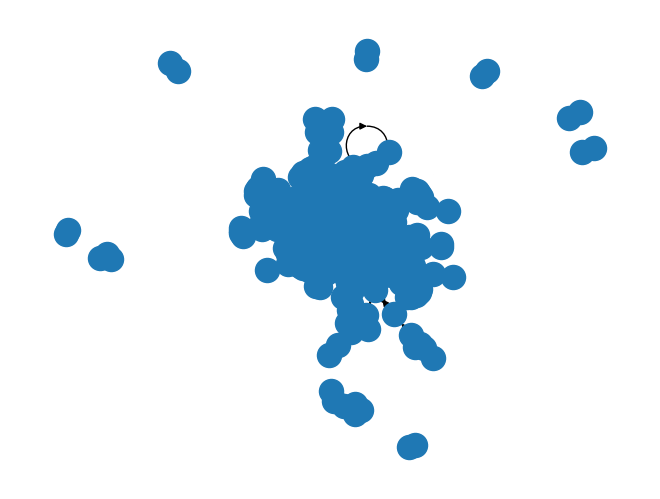

In [13]:
nx.draw(grafo_estaciones)
plt.show()

In [15]:
print(len(grafo_paradas))
print(len(paradas_bondi))


54751
54751


In [16]:
shp = shapefile.Writer("./data/grafo_paradas/grafo_paradas.shp", shapetype=shapefile.POINT)
shp_edges = shapefile.Writer("./data/grafo_paradas/edges", shapeType=shapefile.POLYLINE)
shp.field("Node_ID", "C")
for node, data in grafo_paradas.nodes(data=True):
    lon, lat = data["lon"], data["lat"]
    shp.point(lon, lat)
    shp.record(node)

shp_edges.field("Edge_ID", "C")
for u, v in grafo_paradas.edges():
    lon1, lat1 = grafo_paradas.nodes[u]["lon"], grafo_paradas.nodes[u]["lat"]
    lon2, lat2 = grafo_paradas.nodes[v]["lon"], grafo_paradas.nodes[v]["lat"]
    shp_edges.line([[[lon1, lat1], [lon2, lat2]]])
    shp_edges.record(f"{u}-{v}")


shp_edges.close()
shp.close()

In [37]:
# Write the edges in csv format
for u, v in grafo_paradas.edges():
    grafo_paradas.edges[u, v].pop('BusLine', None)

nx.write_edgelist(grafo_paradas, "./data/adjacencias_paradas.csv")
#open adjacencias_paradas.csv as dataframe, delete the column with the {} and save it as csv back
adjacencias = pd.read_csv("./data/adjacencias_paradas.csv", delimiter=" ")

adjacencias = adjacencias.drop("{}", axis=1)
adjacencias.to_csv("./data/adjacencias_paradas.csv", index=False)

nx.set_edge_attributes(grafo_paradas, edge_attributes, 'BusLine')

# Write the graph in gexf format
nx.write_gexf(grafo_paradas, "./data/grafo_paradas.gexf")


In [51]:
import pandas as pd

nodes = pd.DataFrame(columns=["id", "pos"])

for node, data in grafo_paradas.nodes(data=True):
    pos = f"{data['lat']}, {data['lon']}"
    nodes = pd.concat([nodes, pd.DataFrame({'id': [node], 'pos': [pos]})], ignore_index=True)

nodes["id"] = nodes["id"].astype(int)

# Remove quotation marks and invisible characters from the 'pos' column
nodes["pos"] = nodes["pos"].str.replace(r'[()]', '', regex=True).str.replace(r'\s+', '', regex=True).str.strip()

nodes.to_csv("./data/nodes.csv", index=False)


In [98]:
# Read the CSVs
edges = pd.read_csv("./data/adjacencias_paradas.csv", delimiter=",")
nodes = pd.read_csv("./data/nodes.csv")

# Count the number of times each node appears in the edges CSV
node_counts = edges["0"].value_counts().reset_index()
node_counts.columns = ["id", "count"]

# Sort nodes by the count in descending order
nodes = nodes.merge(node_counts, on="id")
nodes = nodes.sort_values(by="count", ascending=False)
nodes.drop("count", axis=1, inplace=True)

# Limit to the first 30 nodes
nodes = nodes.head(30)

# Create a dictionary to map old node IDs to new node IDs
id_mapping = dict(zip(nodes["id"], range(100)))

# Save the selected nodes to nodes100.csv
nodes.to_csv("./data/nodes30.csv", index=False)

# Rename columns
edges.columns = ["id1", "id2"]

# Filter edges for the 100 nodes in nodes100.csv
edges = edges[edges["id1"].isin(nodes["id"]) & edges["id2"].isin(nodes["id"])]

# Map old node IDs to new node IDs
edges["id1"] = edges["id1"].map(id_mapping)
edges["id2"] = edges["id2"].map(id_mapping)

# Save the filtered edges to edges100.csv
edges.to_csv("./data/edges30.csv", index=False)

